## 正常YOLOv11实验

In [2]:
import os
from pathlib import Path
from latex_converter import LatexConverter
import pandas as pd
cur_file_dir = Path(os.getcwd())
model_order_map = {
    'yolo11x': 0,
    'yolo11m': 1,
    'yolov8x': 2,
    'yolov8m': 3,
    'yolov5xu': 4,
    'yolov5mu': 5,
    'yolov3-sppu': 6,
    'yolov3u': 7,
}
method_rename_map = {
    'rcp': r'$\mathrm{RCP}_{N}$',
    'odpv': 'ODPV',
    'pgd': 'PGD',
    'square_attack': 'SA',
    'median_nms': 'MS',
}
column_rename_map = {
    'epsilon': r'$\varepsilon$',
    '0.5 delta pgd' : r'${\tau=0.5}$',
    '0.7 delta pgd' : r'${\tau=0.7}$',
    '0.5 delta rcp' : r'${\tau=0.5}$',
    '0.7 delta rcp' : r'${\tau=0.7}$',
    '0.5 delta odpv' : r'${\tau=0.5}$',
    '0.7 delta odpv' : r'${\tau=0.7}$',
    'CRA 0.5': r'$\mathrm{CRA}_{0.5}$',
    'CRA 0.7': r'$\mathrm{CRA}_{0.7}$',
}
data_dir = cur_file_dir.parent / "data" / "origin"

def rename_df_columns(df, mapping=None, case=None, prefix='', suffix='', replace_spaces=None, strip=True, inplace=False):
    """
    Rename dataframe columns with small utilities.
    - mapping: dict old_name -> new_name (applied before other transforms)
    - case: 'lower' or 'upper' or None
    - prefix/suffix: strings added to every column name
    - replace_spaces: None or string to replace spaces with (e.g. '_')
    - strip: whether to strip whitespace from column names
    - inplace: if True modifies df in-place and returns None, else returns new df
    """
    if not inplace:
        df = df.copy()
    cols = df.columns.tolist()
    new_cols = []
    for c in cols:
        new = c
        if strip and isinstance(new, str):
            new = new.strip()
        if mapping and c in mapping:
            new = mapping[c]
        if replace_spaces and isinstance(new, str):
            new = new.replace(' ', replace_spaces)
        if case == 'lower' and isinstance(new, str):
            new = new.lower()
        elif case == 'upper' and isinstance(new, str):
            new = new.upper()
        new = f"{prefix}{new}{suffix}"
        new_cols.append(new)
    df.columns = new_cols
    return None if inplace else df

def replace_in_columns(df, replacements, regex=False, inplace=False):
    """
    Replace specific values in specified columns.
    - replacements: dict where keys are column names and values are either:
         * dict(old_value -> new_value, ...)
         * list/tuple of (pattern, repl) pairs
         * scalar/Series/list accepted by pandas.Series.replace
    - regex: passed to pandas.Series.replace (useful when patterns are regex)
    - inplace: if True modifies df in-place and returns None, else returns new df
    Example:
        replace_in_columns(df, {'model': {'yolo11x': 'yolov11x', 'yolo11m': 'yolov11m'}})
    """
    if not inplace:
        df = df.copy()
    for col, repl in replacements.items():
        if col not in df.columns:
            continue
        # Use pandas replace which accepts dict, list of pairs, regex flag, etc.
        df[col] = df[col].replace(repl, regex=regex)
    return None if inplace else df


def bold_best_in_groups(df, groupby, columns, mode='max', fmt='{:.2f}', latex=True):
    """
    Wrap the best value(s) in each group with LaTeX \\textbf{...} (or markdown **...**).
    - df: pandas.DataFrame
    - groupby: list of column names to group by
    - columns: list of column names to consider for bolding
    - mode: 'max' or 'min' (which value is considered better)
    - fmt: format string for numeric values (used before wrapping)
    - latex: if True use LaTeX \\textbf{...}, else use Markdown **...**
    Returns a copy of df with selected cells converted to strings and bolded.
    """
    import pandas as pd
    import numpy as np

    out = df.copy()
    # operate on display column names (they may be already renamed)
    for _, group in out.groupby(groupby, sort=False):
        # group is a view of out with original index preserved
        for col in columns:
            if col not in out.columns:
                continue
            # try to coerce to numeric to decide best; preserve original values for formatting
            vals = pd.to_numeric(group[col], errors='coerce')
            if vals.dropna().empty:
                continue
            if mode == 'max':
                best_mask = vals == vals.max()
            else:
                best_mask = vals == vals.min()
            # iterate indices where best_mask True
            for idx, is_best in best_mask.items():
                if not is_best:
                    continue
                orig_val = group.at[idx, col]
                # format numeric values, leave others as str
                if isinstance(orig_val, (int, float, np.floating, np.integer)) or pd.api.types.is_numeric_dtype(type(orig_val)):
                    try:
                        formatted = fmt.format(orig_val)
                    except Exception:
                        # fallback
                        formatted = str(orig_val)
                else:
                    formatted = str(orig_val)
                if latex:
                    out.at[idx, col] = r'\textbf{' + formatted + '}'
                else:
                    out.at[idx, col] = '**' + formatted + '**'
    return out

def reformat_df(df, bold_cfgs=None):
    filtered_df = df[~df['method'].isin(['pgd', 'square_attack'])]
    filtered_df['model'] = filtered_df['model'].replace('yolo11x', 'yolov9x')
    filtered_df['model'] = filtered_df['model'].replace('yolo11m', 'yolov9m')
    filtered_df = filtered_df.sort_values(by=['model', 'epsilon', 'method'])
    # change model yolo11x to yolov11
    filtered_df['model'] = filtered_df['model'].replace('yolov9x', 'yolov11x')
    filtered_df['model'] = filtered_df['model'].replace('yolov9m', 'yolov11m')
    rename_col_map = {
        'epsilon': r'$\varepsilon$',
        '0.5 delta pgd' : r'${\tau=0.5}$',
        '0.7 delta pgd' : r'${\tau=0.7}$',
    }
    replace_col_map = {
        'model': {
            'yolov11x': 'v11x',
            'yolov11m': 'v11m',
            'yolov8x': 'v8x',
            'yolov8m': 'v8m',
            'yolov5xu': 'v5x',
            'yolov5mu': 'v5m',
            'yolov3-sppu': 'v3spp',
            'yolov3u': 'v3',
        },
        'method': {
            'rcp' : r'$\mathrm{RCP}_N$',
            'odpv': r'Ours'
        },
        r'$\varepsilon$': {
            '1/255' : r'$\frac{1}{255}$',
            '2/255' : r'$\frac{2}{255}$',
            '4/255' : r'$\frac{4}{255}$',
            '8/255' : r'$\frac{8}{255}$',
        }
    }
    filtered_df = rename_df_columns(filtered_df, mapping=rename_col_map, inplace=False)
    filtered_df = replace_in_columns(filtered_df, replacements=replace_col_map, inplace=False)

    # bold_cfg example:
    # bold_cfg = {
    #   'groupby': [r'$\varepsilon$'],           # group key(s) after renaming
    #   'columns': [r'${\tau=0.5}$', r'${\tau=0.7}$'],  # columns to bold
    #   'mode': 'min',                            # 'min' or 'max' (which is "better")
    #   'fmt': '{:.2f}',
    #   'latex': True
    # }
    if bold_cfgs:
        for bold_cfg in bold_cfgs:
            gb = bold_cfg.get('groupby')
            cols = bold_cfg.get('columns')
            mode = bold_cfg.get('mode', 'max')
            fmt = bold_cfg.get('fmt', '{:.2f}')
            latex = bold_cfg.get('latex', True)
            if gb and cols:
                filtered_df = bold_best_in_groups(filtered_df, groupby=gb, columns=cols, mode=mode, fmt=fmt, latex=latex)

    return filtered_df

overview_header = r"\multirow{2}{*}{$\varepsilon$} & \multirow{2}{*}{method} & \multirow{2}{*}{model} & \multirow{2}{*}{time} & \multicolumn{2}{c|}{$\Delta_{\mathrm{PGD}}$} & \multirow{2}{*}{model} & \multirow{2}{*}{time} & \multicolumn{2}{c}{$\Delta_{\mathrm{PGD}}$} \\ \cline{5-6} \cline{9-10} & & & & {\small$\tau=0.5$} & {\small$\tau=0.7$} & & & {\small$\tau=0.5$} & {\small$\tau=0.7$} \\"
overview_col_format = r"c|l|c|r|cc|c|r|ccc"


bold_cfgs = [{
  'groupby': [r'$\varepsilon$', 'model'],           # group key(s) after renaming
  'columns': [r'${\tau=0.5}$', r'${\tau=0.7}$'],  # columns to bold
  'mode': 'min',                            # 'min' or 'max' (which is "better")
  'fmt': '{:.2f}',
  'latex': True
},
{
  'groupby': [r'$\varepsilon$', 'model'],           # group key(s) after renaming
  'columns': ['time'],  # columns to bold
  'mode': 'min',                            # 'min' or 'max' (which is "better")
  'fmt': '{:.1f}',
  'latex': True
}]

from common_utils import change_to_2_col, df_to_latex_multirow2


c:\Users\z8701\Documents\MyPaper\YOLO_ICLR\code\common_utils.py:30: SyntaxWarning: invalid escape sequence '\c'
  """
c:\Users\z8701\Documents\MyPaper\YOLO_ICLR\code\common_utils.py:136: SyntaxWarning: invalid escape sequence '\c'
  """


### 预处理数据

In [19]:
import pandas as pd
file_name = "real_world11x.csv"
result_file = data_dir / file_name

def process_data(df, methods_to_process=['rcp', 'odpv'], methods_to_compare=['pgd', 'square_attack', 'rcp']):
    new_dfs = []
    for (model,image,gt_index,epsilon,conf_threshold,iou_threshold), group in df.groupby(['model','image','gt_index','epsilon','conf_threshold','iou_threshold'], sort=False):
        if len(group) != 4 and len(group) != 5:
            print(f"Warning: skipping group with {len(group)} entries for {model}, {image}, {gt_index}, {epsilon}, {conf_threshold}, {iou_threshold}")
            continue
        for method in methods_to_process:
            for target_method in methods_to_compare:
                delta_07 =  abs(group[group['method'] == method]['iou_0.7'].values[0] - group[group['method'] == target_method]['iou_0.7'].values[0])
                delta_05 =  abs(group[group['method'] == method]['iou_0.5'].values[0] - group[group['method'] == target_method]['iou_0.5'].values[0])
                delta = abs(group[group['method'] == method]['iou'].values[0] - group[group['method'] == target_method]['iou'].values[0])
                time = group[group['method'] == method]['time'].values[0]
                TP_07 = (group[group['method'] == method]['iou_0.7'].values[0] > 0) and (group[group['method'] == target_method]['iou_0.7'].values[0] > 0)
                TP_05 = (group[group['method'] == method]['iou_0.5'].values[0] > 0) and (group[group['method'] == target_method]['iou_0.5'].values[0] > 0)
                FP_07 = (group[group['method'] == method]['iou_0.7'].values[0] > 0) and (group[group['method'] == target_method]['iou_0.7'].values[0] == 0)
                FP_05 = (group[group['method'] == method]['iou_0.5'].values[0] > 0) and (group[group['method'] == target_method]['iou_0.5'].values[0] == 0)
                FN_07 = (group[group['method'] == method]['iou_0.7'].values[0] == 0) and (group[group['method'] == target_method]['iou_0.7'].values[0] > 0)
                FN_05 = (group[group['method'] == method]['iou_0.5'].values[0] == 0) and (group[group['method'] == target_method]['iou_0.5'].values[0] > 0)
                TN_07 = (group[group['method'] == method]['iou_0.7'].values[0] == 0) and (group[group['method'] == target_method]['iou_0.7'].values[0] == 0)
                TN_05 = (group[group['method'] == method]['iou_0.5'].values[0] == 0) and (group[group['method'] == target_method]['iou_0.5'].values[0] == 0)
                pgd_bounds_lower_05 = group[(group['method'] == 'pgd')]['iou_0.5'].values[0] < group[(group['method'] == 'rcp')]['iou_0.5'].values[0]
                pgd_bounds_lower_07 = group[(group['method'] == 'pgd')]['iou_0.7'].values[0] < group[(group['method'] == 'rcp')]['iou_0.7'].values[0]
                new_dfs.append({
                    'model': model,
                    'image': image,
                    'gt_index': gt_index,
                    'epsilon': epsilon,
                    'conf_threshold': conf_threshold,
                    'iou_threshold': iou_threshold,
                    'method': method,
                    'target_method': target_method,
                    'iou_0.5': group[group['method'] == method]['iou_0.5'].values[0],
                    'iou_0.7': group[group['method'] == method]['iou_0.7'].values[0],
                    'iou': group[group['method'] == method]['iou'].values[0],
                    'time': time,
                    'iou_0.5_target': group[group['method'] == target_method]['iou_0.5'].values[0],
                    'iou_0.7_target': group[group['method'] == target_method]['iou_0.7'].values[0],
                    'iou_target': group[group['method'] == target_method]['iou'].values[0],
                    'delta_0.5': delta_05,
                    'delta_0.7': delta_07,
                    'delta': delta,
                    'TP_0.5': TP_05,
                    'TP_0.7': TP_07,
                    'FP_0.5': FP_05,
                    'FP_0.7': FP_07,
                    'FN_0.5': FN_05,
                    'FN_0.7': FN_07,
                    'TN_0.5': TN_05,
                    'TN_0.7': TN_07,
                    'pgd_bounds_lower_0.5': pgd_bounds_lower_05,
                    'pgd_bounds_lower_0.7': pgd_bounds_lower_07,
                })
    return pd.DataFrame(new_dfs)
data = process_data(pd.read_csv(result_file))
processed_file_name = file_name.replace(".csv", "_processed.csv")
data.to_csv(data_dir / processed_file_name, index=False)
print(data)

       model   image  gt_index epsilon  conf_threshold  iou_threshold method  \
0    yolo11x   17178         0   1/255            0.45           0.25    rcp   
1    yolo11x   17178         0   1/255            0.45           0.25    rcp   
2    yolo11x   17178         0   1/255            0.45           0.25    rcp   
3    yolo11x   17178         0   1/255            0.45           0.25   odpv   
4    yolo11x   17178         0   1/255            0.45           0.25   odpv   
..       ...     ...       ...     ...             ...            ...    ...   
751  yolo11x  567197         8   2/255            0.45           0.25    rcp   
752  yolo11x  567197         8   2/255            0.45           0.25    rcp   
753  yolo11x  567197         8   2/255            0.45           0.25   odpv   
754  yolo11x  567197         8   2/255            0.45           0.25   odpv   
755  yolo11x  567197         8   2/255            0.45           0.25   odpv   

     target_method   iou_0.5   iou_0.7 

### Overview

In [20]:
file_name = "full_results_processed.csv"
result_file = data_dir / file_name

def get_full_results_df(df, select_methods=['rcp', 'odpv'], target_method='pgd'):
    results = []
    for (model,epsilon, method), group in df.groupby(['model','epsilon','method'], sort=False):
        if method not in select_methods:
            continue
        target_df = group[(group['target_method'] == target_method)]
        if target_df.empty:
            continue
        time = target_df['time'].mean()
        delta_07 = target_df['delta_0.7'].mean()
        delta_05 = target_df['delta_0.5'].mean()
        results.append({
            'model': model,
            'epsilon': epsilon,
            'method': method,
            'time': time,
            f'0.5 delta {target_method}': delta_05,
            f'0.7 delta {target_method}': delta_07,
        })
    results_df = pd.DataFrame(results)
    return results_df
tmp_df = pd.read_csv(result_file)
full_df = get_full_results_df(tmp_df)
print(full_df)

          model epsilon method        time  0.5 delta pgd  0.7 delta pgd
0       yolo11m   1/255    rcp  468.787780       0.532922       0.523076
1       yolo11m   1/255   odpv   59.068590       0.480673       0.431871
2       yolo11m   2/255    rcp  467.750982       0.565049       0.531525
3       yolo11m   2/255   odpv   57.991469       0.495585       0.429905
4       yolo11x   1/255    rcp  618.092214       0.542749       0.537574
5       yolo11x   1/255   odpv  147.180464       0.485261       0.453852
6       yolo11x   2/255    rcp  616.548161       0.616948       0.568675
7       yolo11x   2/255   odpv  141.919963       0.502173       0.435747
8   yolov3-sppu   1/255    rcp  563.488711       0.547076       0.533202
9   yolov3-sppu   1/255   odpv  109.017337       0.490161       0.446673
10  yolov3-sppu   2/255    rcp  562.876263       0.583068       0.541495
11  yolov3-sppu   2/255   odpv  106.280749       0.480057       0.408032
12      yolov3u   1/255    rcp  560.982439       0.

### 计算TP, FP, TN, FN

In [2]:
file_name = "full_results_processed.csv"
result_file = data_dir / file_name
def get_tpr_fpr_tnr_fnr(df, select_methods=['rcp', 'odpv'], target_method='pgd'):
    results = []
    for (model,epsilon, method), group in df.groupby(['model','epsilon','method'], sort=False):
        if method not in select_methods:
            continue
        target_df = group[(group['target_method'] == target_method)]
        pgd_df = group[(group['target_method'] == 'pgd')]
        if target_df.empty:
            continue
        TP_07 = target_df['TP_0.7'].sum()
        FP_07 = target_df['FP_0.7'].sum()
        TN_07 = target_df['TN_0.7'].sum()
        FN_07 = target_df['FN_0.7'].sum()
        TP_05 = target_df['TP_0.5'].sum()
        FP_05 = target_df['FP_0.5'].sum()
        TN_05 = target_df['TN_0.5'].sum()
        FN_05 = target_df['FN_0.5'].sum()
        CRA_05 = target_df[target_df['iou_0.5'] > 0]['TP_0.5'].sum() / len(target_df[target_df['iou_0.5'] > 0])
        CRA_07 = target_df[target_df['iou_0.7'] > 0]['TP_0.7'].sum() / len(target_df[target_df['iou_0.7'] > 0])
        TPR_07 = TP_07 / (TP_07 + FN_07) if (TP_07 + FN_07) > 0 else 0
        FPR_07 = FP_07 / (FP_07 + TN_07) if (FP_07 + TN_07) > 0 else 0
        TNR_07 = TN_07 / (TN_07 + FP_07) if (TN_07 + FP_07) > 0 else 0
        FNR_07 = FN_07 / (FN_07 + TP_07) if (FN_07 + TP_07) > 0 else 0
        TPR_05 = TP_05 / (TP_05 + FN_05) if (TP_05 + FN_05) > 0 else 0
        FPR_05 = FP_05 / (FP_05 + TN_05) if (FP_05 + TN_05) > 0 else 0
        TNR_05 = TN_05 / (TN_05 + FP_05) if (TN_05 + FP_05) > 0 else 0
        FNR_05 = FN_05 / (FN_05 + TP_05) if (FN_05 + TP_05) > 0 else 0
        # CRA_05_square = square_df[square_df['iou_0.5'] > 0]['TP_0.5'].sum() / len(square_df[square_df['iou_0.5'] > 0]) if not square_df[square_df['iou_0.5'] > 0].empty else 0
        # improve_index = pgd_df['iou_0.5_target'] < target_df['iou_0.5_target']
        improves = []
        for _, row in target_df.iterrows():
            if row['iou_0.5'] == 0 and row['iou_0.5_target'] == 0:
                continue
            if row['pgd_bounds_lower_0.5']:
                improve = row['iou_0.5_target'] - row['iou_0.5']
            else:
                improve = row['iou_0.5'] - row['iou_0.5_target']
            improves.append(improve)



        results.append({
            'model': model,
            'epsilon': epsilon,
            'method': method,
            'TPR_0.5': TPR_05,
            'FPR_0.5': FPR_05,
            'TNR_0.5': TNR_05,
            'FNR_0.5': FNR_05,
            'TPR_0.7': TPR_07,
            'FPR_0.7': FPR_07,
            'TNR_0.7': TNR_07,
            'FNR_0.7': FNR_07,
            'CRA_0.5': CRA_05,
            'CRA_0.7': CRA_07,
            'bounds_improvement_0.5': sum(improves) / len(improves) if improves else 0,
            # 'CRA_0.5_square': CRA_05_square,
        })
    results_df = pd.DataFrame(results)
    return results_df
tmp_df = pd.read_csv(result_file)
tpr_fpr_df = get_tpr_fpr_tnr_fnr(tmp_df, select_methods=['odpv'], target_method='rcp')
col_to_format = ['TPR_0.5', 'TPR_0.7', 'FPR_0.5', 'FPR_0.7', 'TNR_0.5', 'TNR_0.7', 'FNR_0.5', 'FNR_0.7', 'CRA_0.5', 'CRA_0.7']
tpr_fpr_df[col_to_format] = tpr_fpr_df[col_to_format].applymap(lambda x: f"{float(x * 100):.1f}")
tpr_fpr_df['bounds_improvement_0.5'] = tpr_fpr_df['bounds_improvement_0.5'].apply(lambda x: f"{float(x):.2f}")
tpr_fpr_df = tpr_fpr_df.drop(columns=['method', 'TPR_0.7', 'FPR_0.7', 'TNR_0.7', 'FNR_0.7', 'CRA_0.7'])

# tpr_fpr_df = tpr_fpr_df.replace(
#     '1/255' , r'$\frac{1}{255}$',
# )
# tpr_fpr_df = tpr_fpr_df.replace(
#     '2/255' , r'$\frac{2}{255}$',
# )
column_1 = [r'TPR (\%)', r'FPR (\%)', r'TNR (\%)', r'FNR (\%)', r'CRA (\%)', r'ABI']  # Updated
pre_index = ['model', r'$\varepsilon$']
df = pd.DataFrame(tpr_fpr_df.values, columns=pre_index + column_1)
df.sort_values(by=['model'], inplace=True, key=lambda x: x.map(model_order_map) if x.name == 'model' else x)
converter = LatexConverter(df)
latex_str = converter.convert(body_region=[((0,0), (16, 2))])

out_file = data_dir / "../tpr_fpr_table.tex"
with open(out_file, "w") as f:
    f.write(latex_str)


{c|c|c|c|c|c|c|c}
\hline
model & $\varepsilon$ & TPR (\%) & FPR (\%) & TNR (\%) & FNR (\%) & CRA (\%) & ABI\\\cline{1-1}\cline{2-2}\cline{3-3}\cline{4-4}\cline{5-5}\cline{6-6}\cline{7-7}\cline{8-8}



/var/folders/n7/cqlvwsyx5fq1w3037nvbxyww0000gn/T/ipykernel_28430/2029246374.py:66: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tpr_fpr_df[col_to_format] = tpr_fpr_df[col_to_format].applymap(lambda x: f"{float(x * 100):.1f}")


### real world

In [7]:
file_name = "real_world11x_processed.csv"
result_file = data_dir / file_name

def bold_content(df, settings = []):
    """
    settings format
    settings = [
        {
            'groupby': ['epsilon', 'model'],           # group key(s) after renaming
            'columns': ['0.5 delta pgd', '0.7 delta pgd'],  # columns to bold
            'mode': 'min',                            # 'min' or 'max' (which is "better")
            'fmt': '{:.2f}',
        },
    
    """
    for setting in settings:
        gb = setting.get('groupby')
        cols = setting.get('columns')
        mode = setting.get('mode', 'max')
        fmt = setting.get('fmt', '{:.2f}')
        for _, group in df.groupby(gb, sort=False):
            # group is a view of out with original index preserved
            for col in cols:
                if col not in df.columns:
                    continue
                # try to coerce to numeric to decide best; preserve original values for formatting
                vals = pd.to_numeric(group[col], errors='coerce')
                if vals.dropna().empty:
                    continue
                if mode == 'max':
                    best_mask = vals == vals.max()
                else:
                    best_mask = vals == vals.min()
                # iterate indices where best_mask True
                for idx, is_best in best_mask.items():
                    if not is_best:
                        try:
                            orig_val = group.at[idx, col]
                            if isinstance(orig_val, (int, float)):
                                formatted = fmt.format(orig_val)
                            else:
                                formatted = str(orig_val)
                            df.at[idx, col] = formatted
                        except Exception:
                            continue
                        df.at[idx, col] = formatted
                    else:
                        orig_val = group.at[idx, col]
                        # format numeric values, leave others as str
                        if isinstance(orig_val, (int, float)):
                            try:
                                formatted = fmt.format(orig_val)
                            except Exception:
                                # fallback
                                formatted = str(orig_val)
                        else:
                            formatted = str(orig_val)
                        df.at[idx, col] = r'\textbf{' + formatted + '}'
    return df


def get_real_world_results_df(df, select_methods=['rcp', 'odpv'], target_method='rcp'):
    results = []
    for (model,epsilon, method), group in df.groupby(['model','epsilon','method'], sort=False):
        if method not in select_methods:
            continue
        target_df = group[(group['target_method'] == target_method)]
        if target_df.empty:
            continue
        time = target_df['time'].mean()
        delta_07 = target_df['delta_0.7'].mean()
        delta_05 = target_df['delta_0.5'].mean()
        results.append({
            'model': model,
            'epsilon': epsilon,
            'method': method,
            'time': time,
            f'0.5 delta {target_method}': delta_05,
            f'0.7 delta {target_method}': delta_07,
            'CRA 0.5' : target_df[target_df['iou_0.5'] > 0]['TP_0.5'].sum() / len(target_df[target_df['iou_0.5'] > 0]) if not target_df[target_df['iou_0.5'] > 0].empty else 0,
            'CRA 0.7' : target_df[target_df['iou_0.7'] > 0]['TP_0.7'].sum() / len(target_df[target_df['iou_0.7'] > 0]) if not target_df[target_df['iou_0.7'] > 0].empty else 0, 
        })
    results_df = pd.DataFrame(results)
    return results_df
tmp_df = pd.read_csv(result_file)
full_df = get_real_world_results_df(tmp_df, select_methods=['rcp', 'odpv'], target_method='pgd')
rcp_df = get_real_world_results_df(tmp_df, select_methods=['rcp', 'odpv'], target_method='rcp')

full_df['CRA 0.5'] = rcp_df['CRA 0.5'].values

full_df['CRA 0.7'] = rcp_df['CRA 0.7'].values

bold_setting = [
    {
      'groupby': ['epsilon', 'model'],           # group key(s) after renaming
      'columns': [f'0.5 delta pgd', f'0.7 delta pgd'],  # columns to bold
      'mode': 'min',                            # 'min' or 'max' (which is "better")
      'fmt': '{:.2f}',
    },
    {
      'groupby': ['epsilon', 'model'],           # group key(s) after renaming
      'columns': ['time'],  # columns to bold
      'mode': 'min',                            # 'min' or 'max' (which is "better")
      'fmt': '{:.1f}',
    },
    {
      'groupby': ['epsilon', 'model'],           # group key(s) after renaming
      'columns': ['CRA 0.5', 'CRA 0.7'],  # columns to bold
      'mode': 'max',                            # 'min' or 'max' (which is "better")
      'fmt': '{:.2f}',
    },
]
tmp_df = pd.read_csv(result_file)
full_df = get_real_world_results_df(tmp_df, select_methods=['rcp', 'odpv', 'median_nms'], target_method='pgd')
rcp_df = get_real_world_results_df(tmp_df, select_methods=['rcp', 'odpv', 'median_nms'], target_method='rcp')

full_df['CRA 0.5'] = rcp_df['CRA 0.5'].values

full_df['CRA 0.7'] = rcp_df['CRA 0.7'].values
bold_setting = [
    {
      'groupby': ['epsilon', 'model'],           # group key(s) after renaming
      'columns': [f'0.5 delta pgd', f'0.7 delta pgd'],  # columns to bold
      'mode': 'min',                            # 'min' or 'max' (which is "better")
      'fmt': '{:.2f}',
    },
    {
      'groupby': ['epsilon', 'model'],           # group key(s) after renaming
      'columns': ['time'],  # columns to bold
      'mode': 'min',                            # 'min' or 'max' (which is "better")
      'fmt': '{:.1f}',
    },
    {
      'groupby': ['epsilon', 'model'],           # group key(s) after renaming
      'columns': ['CRA 0.5', 'CRA 0.7'],  # columns to bold
      'mode': 'max',                            # 'min' or 'max' (which is "better")
      'fmt': '{:.2f}',
    },
]

full_df = bold_content(full_df, settings=bold_setting)
full_df = full_df.applymap(lambda x: method_rename_map[x] if x in method_rename_map else x)
pre_column = pd.MultiIndex.from_tuples([('model', 'model'), (r'$\varepsilon$', r'$\varepsilon$'), ('method', 'method'), ('time', 'time')])
suffix_column = pd.MultiIndex.from_product([[r'$\Delta_{\mathrm{PGD}}$', 'CRA'], [r'${\tau=0.5}$', r'${\tau=0.7}$']])
columns = pre_column.append(suffix_column)
new_df = pd.DataFrame(full_df.values, columns=columns)
converter = LatexConverter(new_df)
latex_str = converter.convert(body_region=[((0,0), (6, 2))])
print(latex_str )

out_file = data_dir / "../real_world.tex"
with open(out_file, "w+") as f:
    f.write(latex_str)

{c|c|c|c|c|c|c|c}
\hline
\multirow{2}{*}{model} & \multirow{2}{*}{$\varepsilon$} & \multirow{2}{*}{method} & \multirow{2}{*}{time} & \multicolumn{2}{c|}{$\Delta_{\mathrm{PGD}}$} & \multicolumn{2}{c}{CRA}\\\cline{5-6}\cline{7-8}
 &  &  &  & ${\tau=0.5}$ & ${\tau=0.7}$ & ${\tau=0.5}$ & ${\tau=0.7}$\\\cline{1-1}\cline{2-2}\cline{3-3}\cline{4-4}\cline{5-5}\cline{6-6}\cline{7-7}\cline{8-8}

\begin{tabular}
{c|c|c|c|c|c|c|c}
\hline
\multirow{2}{*}{model} & \multirow{2}{*}{$\varepsilon$} & \multirow{2}{*}{method} & \multirow{2}{*}{time} & \multicolumn{2}{c|}{$\Delta_{\mathrm{PGD}}$} & \multicolumn{2}{c}{CRA}\\\cline{5-6}\cline{7-8}
 &  &  &  & ${\tau=0.5}$ & ${\tau=0.7}$ & ${\tau=0.5}$ & ${\tau=0.7}$\\\cline{1-1}\cline{2-2}\cline{3-3}\cline{4-4}\cline{5-5}\cline{6-6}\cline{7-7}\cline{8-8}
\multirow{4}{*}{yolo11x}  & \multirow{2}{*}{1/255}  & $\mathrm{RCP}_{N}$  & 571.0  & 0.53  & 0.52  & \textbf{1.00}  & \textbf{1.00} \\ 
\cline{3-3}\cline{4-4}\cline{5-5}\cline{6-6}\cline{7-7}\cline{8-8}
 &  

C:\Users\z8701\AppData\Local\Temp\ipykernel_17616\548867513.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.53' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, col] = formatted
C:\Users\z8701\AppData\Local\Temp\ipykernel_17616\548867513.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.52' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, col] = formatted
C:\Users\z8701\AppData\Local\Temp\ipykernel_17616\548867513.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '571.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, col] = formatted
C:\Users\z8701\AppData\Local\Temp\ip

### 不同分布 && median smoothing

In [8]:
file_name = "median_compare_processed.csv"
result_file = data_dir / file_name

def get_real_world_results_df(df, select_methods=['rcp', 'odpv'], target_method='rcp'):
    results = []
    for (model,epsilon, method), group in df.groupby(['model','epsilon','method'], sort=False):
        if method not in select_methods:
            continue
        target_df = group[(group['target_method'] == target_method)]
        if target_df.empty:
            continue
        time = target_df['time'].mean()
        delta_07 = target_df['delta_0.7'].mean()
        delta_05 = target_df['delta_0.5'].mean()
        results.append({
            'model': model,
            'epsilon': epsilon,
            'method': method,
            # 'time': time,
            f'0.5 delta {target_method}': delta_05,
            f'0.7 delta {target_method}': delta_07,
            'CRA 0.5' : target_df[target_df['iou_0.5'] > 0]['TP_0.5'].sum() / len(target_df[target_df['iou_0.5'] > 0]) if not target_df[target_df['iou_0.5'] > 0].empty else 0,
            'CRA 0.7' : target_df[target_df['iou_0.7'] > 0]['TP_0.7'].sum() / len(target_df[target_df['iou_0.7'] > 0]) if not target_df[target_df['iou_0.7'] > 0].empty else 0, 
        })
    results_df = pd.DataFrame(results)
    return results_df
tmp_df = pd.read_csv(result_file)
full_df = get_real_world_results_df(tmp_df, select_methods=['rcp', 'odpv', 'median_nms'], target_method='pgd')
rcp_df = get_real_world_results_df(tmp_df, select_methods=['rcp', 'odpv', 'median_nms'], target_method='rcp')

full_df['CRA 0.5'] = rcp_df['CRA 0.5'].values

full_df['CRA 0.7'] = rcp_df['CRA 0.7'].values
bold_setting = [
    {
      'groupby': ['epsilon', 'model'],           # group key(s) after renaming
      'columns': [f'0.5 delta pgd', f'0.7 delta pgd'],  # columns to bold
      'mode': 'min',                            # 'min' or 'max' (which is "better")
      'fmt': '{:.2f}',
    },
    {
      'groupby': ['epsilon', 'model'],           # group key(s) after renaming
      'columns': ['time'],  # columns to bold
      'mode': 'min',                            # 'min' or 'max' (which is "better")
      'fmt': '{:.1f}',
    },
    {
      'groupby': ['epsilon', 'model'],           # group key(s) after renaming
      'columns': ['CRA 0.5', 'CRA 0.7'],  # columns to bold
      'mode': 'max',                            # 'min' or 'max' (which is "better")
      'fmt': '{:.2f}',
    },
]

full_df = bold_content(full_df, settings=bold_setting)
full_df = full_df.applymap(lambda x: method_rename_map[x] if x in method_rename_map else x)
pre_column = pd.MultiIndex.from_tuples([('model', 'model'), (r'$\varepsilon$', r'$\varepsilon$'), ('method', 'method')])
suffix_column = pd.MultiIndex.from_product([[r'$\Delta_{\mathrm{PGD}}$', 'CRA'], [r'${\tau=0.5}$', r'${\tau=0.7}$']])
columns = pre_column.append(suffix_column)
new_df = pd.DataFrame(full_df.values, columns=columns)
converter = LatexConverter(new_df)
latex_str = converter.convert(body_region=[((0,0), (6, 2))])
print(latex_str )

out_file = data_dir / "../median_compare.tex"
with open(out_file, "w+") as f:
    f.write(latex_str)

{c|c|c|c|c|c|c}
\hline
\multirow{2}{*}{model} & \multirow{2}{*}{$\varepsilon$} & \multirow{2}{*}{method} & \multicolumn{2}{c|}{$\Delta_{\mathrm{PGD}}$} & \multicolumn{2}{c}{CRA}\\\cline{4-5}\cline{6-7}
 &  &  & ${\tau=0.5}$ & ${\tau=0.7}$ & ${\tau=0.5}$ & ${\tau=0.7}$\\\cline{1-1}\cline{2-2}\cline{3-3}\cline{4-4}\cline{5-5}\cline{6-6}\cline{7-7}

\begin{tabular}
{c|c|c|c|c|c|c}
\hline
\multirow{2}{*}{model} & \multirow{2}{*}{$\varepsilon$} & \multirow{2}{*}{method} & \multicolumn{2}{c|}{$\Delta_{\mathrm{PGD}}$} & \multicolumn{2}{c}{CRA}\\\cline{4-5}\cline{6-7}
 &  &  & ${\tau=0.5}$ & ${\tau=0.7}$ & ${\tau=0.5}$ & ${\tau=0.7}$\\\cline{1-1}\cline{2-2}\cline{3-3}\cline{4-4}\cline{5-5}\cline{6-6}\cline{7-7}
\multirow{6}{*}{yolo11x}  & \multirow{3}{*}{1/255}  & $\mathrm{RCP}_{N}$  & 0.45  & 0.47  & \textbf{1.00}  & \textbf{1.00} \\ 
\cline{3-3}\cline{4-4}\cline{5-5}\cline{6-6}\cline{7-7}
 &  & ODPV  & \textbf{0.42}  & \textbf{0.40}  & 0.99  & 0.98 \\ 
\cline{3-3}\cline{4-4}\cline{5-5}\cline

C:\Users\z8701\AppData\Local\Temp\ipykernel_17616\548867513.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.45' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, col] = formatted
C:\Users\z8701\AppData\Local\Temp\ipykernel_17616\548867513.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.47' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, col] = formatted
C:\Users\z8701\AppData\Local\Temp\ipykernel_17616\548867513.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{1.00}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, col] = r'\textbf{' + formatted + '}'
C:\Users

### ablation

In [38]:
import pandas as pd
file_name = "ablation_new2_processed.csv"
result_file = data_dir / file_name

df = pd.read_csv(result_file)
results = []
def get_ablation_results(df, select_methods=['rcp', 'odpv'], target_method='pgd'):
    df = df[df['method'].isin(select_methods) & (df['target_method'] == target_method)]
    results = []
    for (model, epsilon, conf_threshold, iou_threshold), group in df.groupby(['model', 'epsilon', 'conf_threshold', 'iou_threshold'], sort=False):
        for method in select_methods:
            sub_group = group[group['method'] == method]
            if sub_group.empty:
                continue
            time_mean = sub_group['time'].sum() / sub_group.shape[0]
            delta_05_mean = sub_group['delta_0.5'].sum() / sub_group.shape[0]
            delta_07_mean = sub_group['delta_0.7'].sum() / sub_group.shape[0]
            results.append({
                'model': model,
                'epsilon': epsilon,
                'conf_threshold': conf_threshold,
                'iou_threshold': iou_threshold,
                'method': method,
                'time': time_mean,
                f'0.5 delta {target_method}': delta_05_mean,
                f'0.7 delta {target_method}': delta_07_mean,
            })
            

    return pd.DataFrame(results)
print("Ablation results:")
ablation_df = get_ablation_results(df)
print(ablation_df)

Ablation results:
      model epsilon  conf_threshold  iou_threshold method         time  \
0   yolo11x   1/255            0.25           0.25    rcp  1195.881088   
1   yolo11x   1/255            0.25           0.25   odpv   139.146163   
2   yolo11x   1/255            0.25           0.45    rcp  1228.521612   
3   yolo11x   1/255            0.25           0.45   odpv   147.540168   
4   yolo11x   1/255            0.25           0.65    rcp  1244.995187   
5   yolo11x   1/255            0.25           0.65   odpv   135.088212   
6   yolo11x   1/255            0.45           0.25    rcp  1195.326953   
7   yolo11x   1/255            0.45           0.25   odpv   148.359118   
8   yolo11x   1/255            0.45           0.45    rcp  1201.758459   
9   yolo11x   1/255            0.45           0.45   odpv   138.176249   
10  yolo11x   1/255            0.45           0.65    rcp  1249.529173   
11  yolo11x   1/255            0.45           0.65   odpv   144.617906   
12  yolo11x   1/255 

#### 热力图

<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:122: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:122: SyntaxWarning: invalid escape sequence '\m'
/var/folders/n7/cqlvwsyx5fq1w3037nvbxyww0000gn/T/ipykernel_52677/3455013506.py:68: SyntaxWarning: invalid escape sequence '\m'
  axes[i, 0].set_title(f'$\mathrm{{RCP}}_N - ${metric_map[metric]}')
/var/folders/n7/cqlvwsyx5fq1w3037nvbxyww0000gn/T/ipykernel_52677/3455013506.py:122: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_title(f'$\mathrm{{RCP}}_N - ${metric_map[metric]}')


Creating combined heatmaps...


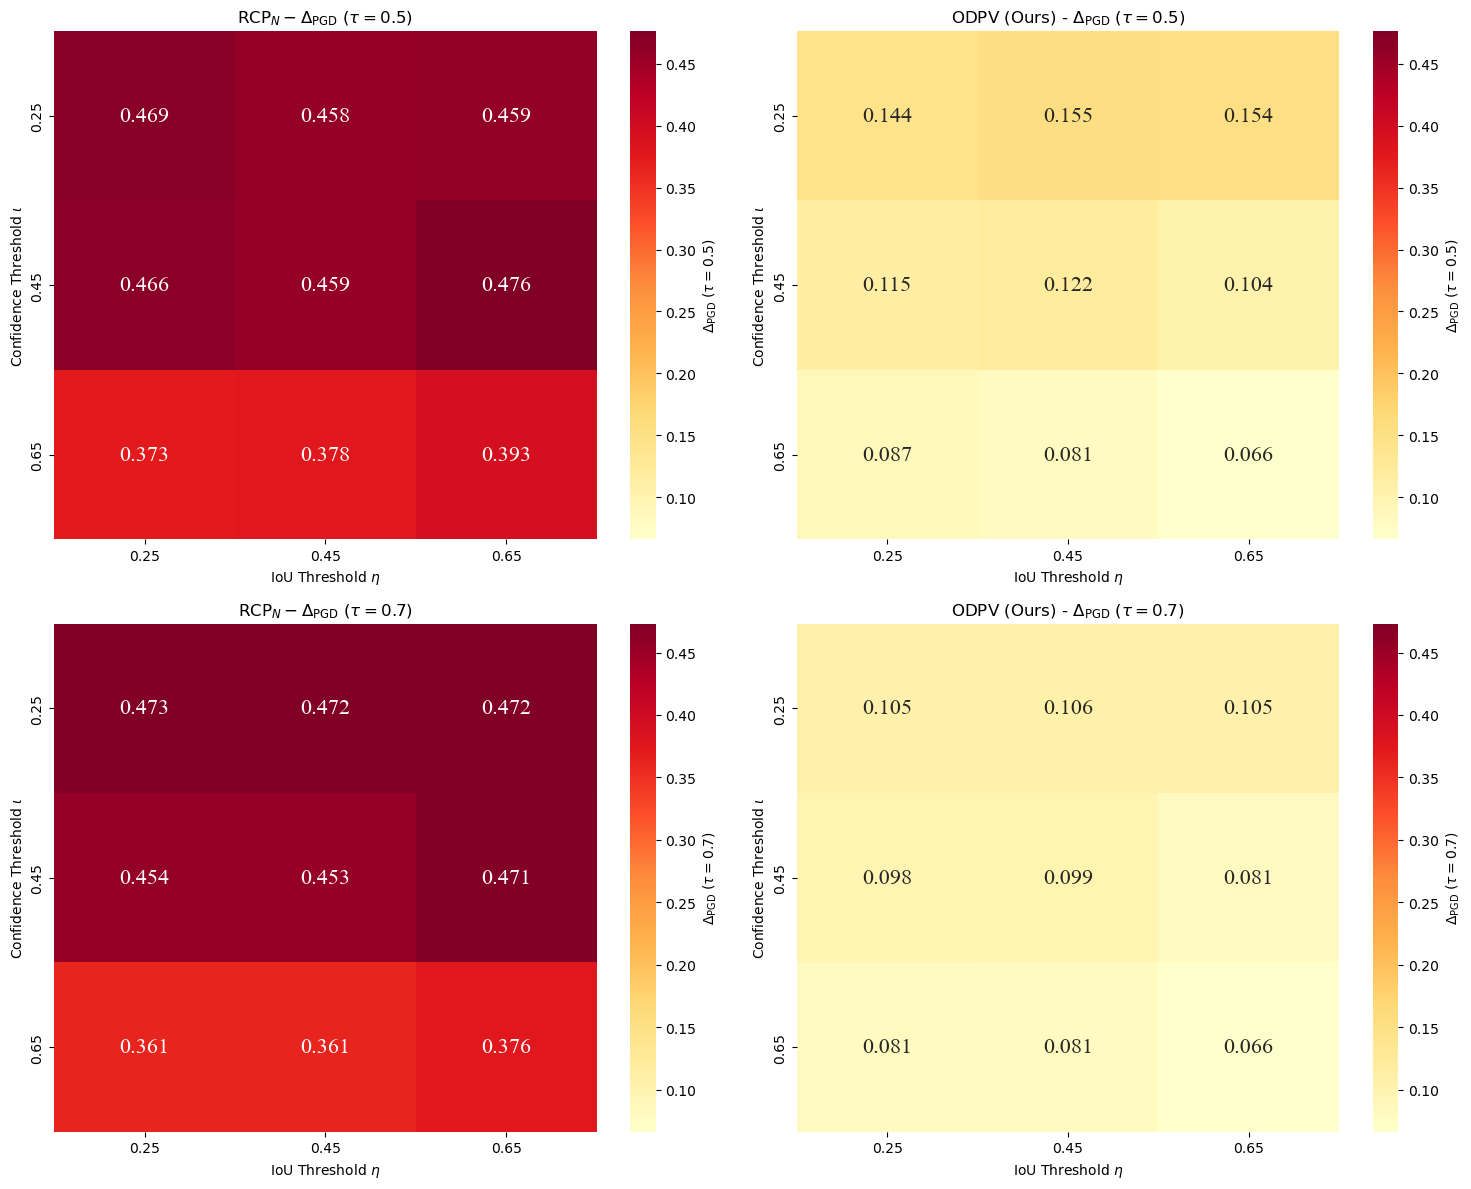


Creating separate heatmaps...


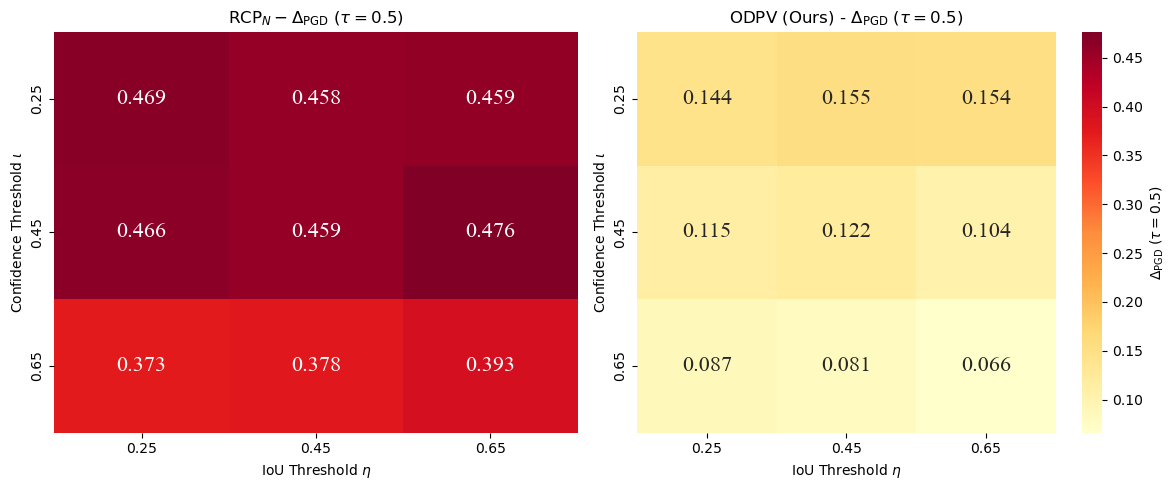

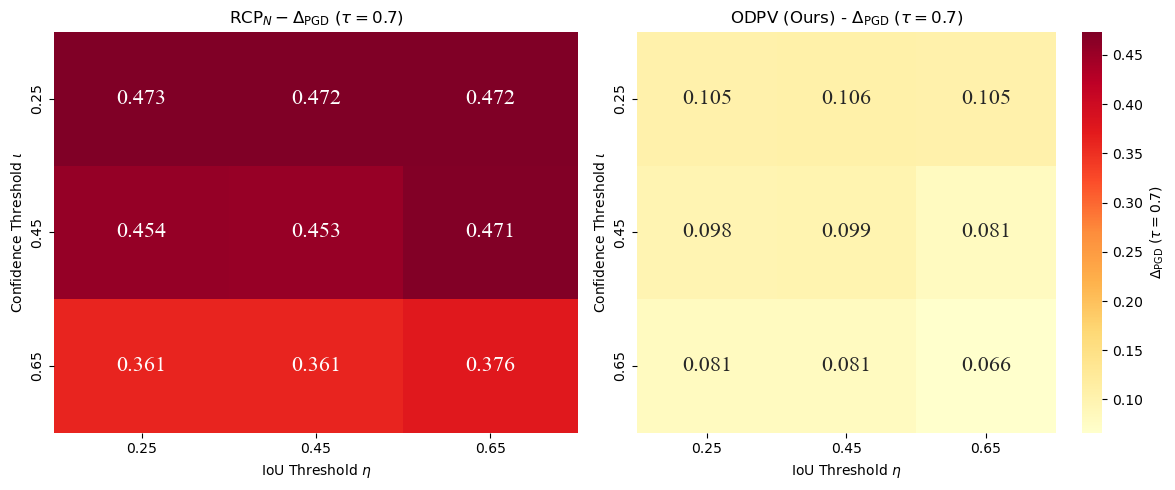


Data Summary:

0.5 delta pgd:
  rcp: mean=0.437, std=0.042, min=0.373, max=0.476
  odpv: mean=0.114, std=0.033, min=0.066, max=0.155

0.7 delta pgd:
  rcp: mean=0.433, std=0.051, min=0.361, max=0.473
  odpv: mean=0.091, std=0.014, min=0.066, max=0.106


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],   # Windows 下常用名称
    'font.size': 12,                     # 全局字体大小（可调整）
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'mathtext.fontset': 'stix'           # 如果有 latex/mathtext，使字体匹配
})
metric_map = {
    '0.5 delta pgd': r'$\Delta_{\mathrm{PGD}}$ ($\tau=0.5$)',
    '0.7 delta pgd': r'$\Delta_{\mathrm{PGD}}$ ($\tau=0.7$)',
}
annot_style = {'fontsize': 16, 'fontfamily': 'Times New Roman'}  # fontsize 改为所需大小

# 为每个方法和指标创建透视表
def create_heatmap_data(df, metric):
    """为指定指标创建热力图数据"""
    pivot_data = {}
    for method in ['rcp', 'odpv']:
        method_df = df[df['method'] == method]
        pivot = method_df.pivot_table(
            values=metric, 
            index=['conf_threshold'], 
            columns=['iou_threshold'], 
            aggfunc='mean'
        )
        pivot_data[method] = pivot
    return pivot_data

# 创建热力图
def plot_heatmaps(ablation_df):
    # 设置图形样式
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 为两个指标创建热力图
    metrics = ['0.5 delta pgd', '0.7 delta pgd']
    
    for i, metric in enumerate(metrics):
        pivot_data = create_heatmap_data(ablation_df, metric)
        
        # 计算全局的最小值和最大值用于统一颜色条
        all_values = []
        for method_data in pivot_data.values():
            all_values.extend(method_data.values.flatten())
        vmin = np.nanmin(all_values)
        vmax = np.nanmax(all_values)

        
        # 绘制 RCP 方法的热力图
        sns.heatmap(
            pivot_data['rcp'], 
            ax=axes[i, 0],
            annot=True, 
            fmt='.3f',
            cmap='YlOrRd',
            vmin=vmin,
            vmax=vmax,
            annot_kws=annot_style,
            cbar_kws={'label': metric_map[metric]}
        )
        axes[i, 0].set_title(f'$\mathrm{{RCP}}_N - ${metric_map[metric]}')
        axes[i, 0].set_xlabel(r'IoU Threshold $\eta$')
        axes[i, 0].set_ylabel(r'Confidence Threshold $\iota$')

        # 绘制 ODPV 方法的热力图
        im = sns.heatmap(
            pivot_data['odpv'], 
            ax=axes[i, 1],
            annot=True, 
            fmt='.3f',
            cmap='YlOrRd',
            vmin=vmin,
            vmax=vmax,
            annot_kws=annot_style,
            cbar_kws={'label': metric_map[metric]}
        )
        axes[i, 1].set_title(f'ODPV (Ours) - {metric_map[metric]}')
        axes[i, 1].set_xlabel(r'IoU Threshold $\eta$')
        axes[i, 1].set_ylabel(r'Confidence Threshold $\iota$')

    plt.tight_layout()
    plt.show()
    
    # 保存图像
    fig.savefig(data_dir / '../../image/ablation_heatmaps.png', dpi=300, bbox_inches='tight')
    fig.savefig(data_dir / '../../image/ablation_heatmaps.pdf', bbox_inches='tight')

# 创建单独的热力图（每个指标一张图）
def plot_separate_heatmaps(ablation_df):
    metrics = ['0.5 delta pgd', '0.7 delta pgd']
    
    for metric in metrics:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        pivot_data = create_heatmap_data(ablation_df, metric)
        
        # 计算全局的最小值和最大值用于统一颜色条
        all_values = []
        for method_data in pivot_data.values():
            all_values.extend(method_data.values.flatten())
        vmin = np.nanmin(all_values)
        vmax = np.nanmax(all_values)
        
        # RCP 热力图
        sns.heatmap(
            pivot_data['rcp'], 
            ax=axes[0],
            annot=True, 
            fmt='.3f',
            cmap='YlOrRd',
            vmin=vmin,
            vmax=vmax,
            annot_kws=annot_style,
            cbar=False
        )
        axes[0].set_title(f'$\mathrm{{RCP}}_N - ${metric_map[metric]}')
        axes[0].set_xlabel(r'IoU Threshold $\eta$')
        axes[0].set_ylabel(r'Confidence Threshold $\iota$')
        
        # ODPV 热力图
        im = sns.heatmap(
            pivot_data['odpv'], 
            ax=axes[1],
            annot=True, 
            fmt='.3f',
            cmap='YlOrRd',
            vmin=vmin,
            vmax=vmax,
            cbar=True,
            annot_kws=annot_style,
            cbar_kws={'label': metric_map[metric]}
        )
        axes[1].set_title(f'ODPV (Ours) - {metric_map[metric]}')
        axes[1].set_xlabel(r'IoU Threshold $\eta$')
        axes[1].set_ylabel(r'Confidence Threshold $\iota$')
        
        # plt.suptitle(f'Ablation Study: {metric}', fontsize=16, y=1.02)
        plt.tight_layout()
        
        # 保存单独的图像
        safe_metric = metric.replace(' ', '_').replace('.', '_')
        fig.savefig(data_dir / f'../../image/ablation_{safe_metric}.png', dpi=300, bbox_inches='tight')
        fig.savefig(data_dir / f'../../image/ablation_{safe_metric}.pdf', bbox_inches='tight')

        plt.show()

# 执行绘图
print("Creating combined heatmaps...")
plot_heatmaps(ablation_df)

print("\nCreating separate heatmaps...")
plot_separate_heatmaps(ablation_df)

# 打印数据摘要
print("\nData Summary:")
for metric in ['0.5 delta pgd', '0.7 delta pgd']:
    print(f"\n{metric}:")
    for method in ['rcp', 'odpv']:
        method_data = ablation_df[ablation_df['method'] == method][metric]
        print(f"  {method}: mean={method_data.mean():.3f}, std={method_data.std():.3f}, min={method_data.min():.3f}, max={method_data.max():.3f}")

### 不同分布

### 统计

In [15]:
from pathlib import Path
import os
import pandas as pd
cur_file_dir = Path(os.getcwd())
data_dir = cur_file_dir.parent / "data" / "origin"
file_name = "full_results.csv"
result_file = data_dir / file_name
tmp_df = pd.read_csv(result_file)

image_unique_counts = tmp_df['image'].nunique()
print(f"Unique images count: {image_unique_counts}")


total_box = 0
for image, group in tmp_df.groupby('image'):
    total_box += group['gt_index'].nunique()
    
pgd_df = tmp_df[tmp_df['method'] == 'rcp']
col = ['Model', r'$\varepsilon$', r'#robust box ($\tau=0.5$)', r'#not robust box ($\tau=0.5$)',  r'#robust box ($\tau=0.7$)', r'#not robust box ($\tau=0.7$)']
info = []
for (model, epsilon), group in pgd_df.groupby(['model', 'epsilon']):
    robust_box_0_5, not_robust_box_0_5 = 0, 0
    robust_box_0_7, not_robust_box_0_7 = 0, 0
    for image, img_group in group.groupby('image'):
        robust_box_0_5 += img_group[img_group['iou_0.5'] > 0]['gt_index'].nunique()
        not_robust_box_0_5 += img_group[img_group['iou_0.5'] == 0]['gt_index'].nunique()
        robust_box_0_7 += img_group[img_group['iou_0.7'] > 0]['gt_index'].nunique()
        not_robust_box_0_7 += img_group[img_group['iou_0.7'] == 0]['gt_index'].nunique()
    info.append({
        'Model': model,
        '$\varepsilon$': epsilon,
        '#robust box ($\tau=0.5$)': robust_box_0_5,
        '#not robust box ($\tau=0.5$)': not_robust_box_0_5,
        '#robust box ($\tau=0.7$)': robust_box_0_7,
        '#not robust box ($\tau=0.7$)': not_robust_box_0_7,
    })
    # print(f"Model: {model}, Epsilon: {epsilon}")
    # print(f"  IoU 0.5 - Robust boxes: {robust_box_0_5}, Not robust boxes: {not_robust_box_0_5}, Robustness: {robust_box_0_5 / (robust_box_0_5 + not_robust_box_0_5):.3f}")
    # print(f"  IoU 0.7 - Robust boxes: {robust_box_0_7}, Not robust boxes: {not_robust_box_0_7}, Robustness: {robust_box_0_7 / (robust_box_0_7 + not_robust_box_0_7):.3f}")

# to markdown table
info_df = pd.DataFrame(info)
print(info_df.to_markdown(index=False))


Unique images count: 100
| Model       | $arepsilon$       |     #robust box ($	au=0.5$) |     #not robust box ($	au=0.5$) |     #robust box ($	au=0.7$) |     #not robust box ($	au=0.7$) |
|:------------|:------|----:|----:|----:|----:|
| yolo11m     | 1/255 | 363 | 164 | 335 | 192 |
| yolo11m     | 2/255 | 346 | 181 | 315 | 212 |
| yolo11x     | 1/255 | 390 | 137 | 348 | 179 |
| yolo11x     | 2/255 | 379 | 148 | 335 | 192 |
| yolov3-sppu | 1/255 | 364 | 163 | 332 | 195 |
| yolov3-sppu | 2/255 | 356 | 171 | 320 | 207 |
| yolov3u     | 1/255 | 374 | 153 | 338 | 189 |
| yolov3u     | 2/255 | 365 | 162 | 327 | 200 |
| yolov5mu    | 1/255 | 354 | 173 | 316 | 211 |
| yolov5mu    | 2/255 | 344 | 183 | 301 | 226 |
| yolov5xu    | 1/255 | 387 | 140 | 354 | 173 |
| yolov5xu    | 2/255 | 372 | 155 | 337 | 190 |
| yolov8m     | 1/255 | 376 | 151 | 342 | 185 |
| yolov8m     | 2/255 | 361 | 166 | 327 | 200 |
| yolov8x     | 1/255 | 385 | 142 | 348 | 179 |
| yolov8x     | 2/255 | 370 | 157 | 337 | 


=== ε=1/255 数据统计信息 ===
模型 yolo11m: ODPV=527 boxes, RCP=527 boxes
模型 yolo11x: ODPV=527 boxes, RCP=527 boxes
模型 yolov3-sppu: ODPV=527 boxes, RCP=527 boxes
模型 yolov3u: ODPV=527 boxes, RCP=527 boxes
模型 yolov5mu: ODPV=527 boxes, RCP=527 boxes
模型 yolov5xu: ODPV=527 boxes, RCP=527 boxes
模型 yolov8m: ODPV=527 boxes, RCP=527 boxes
模型 yolov8x: ODPV=527 boxes, RCP=527 boxes

=== ε=2/255 数据统计信息 ===
模型 yolo11m: ODPV=527 boxes, RCP=527 boxes
模型 yolo11x: ODPV=527 boxes, RCP=527 boxes
模型 yolov3-sppu: ODPV=527 boxes, RCP=527 boxes
模型 yolov3u: ODPV=527 boxes, RCP=527 boxes
模型 yolov5mu: ODPV=527 boxes, RCP=527 boxes
模型 yolov5xu: ODPV=527 boxes, RCP=527 boxes
模型 yolov8m: ODPV=527 boxes, RCP=527 boxes
模型 yolov8x: ODPV=527 boxes, RCP=527 boxes

=== 平均时间统计 ===

ε=1/255:
  模型 yolo11m:
    ODPV: 平均时间 = 59.07秒
    RCP: 平均时间 = 468.79秒
  模型 yolo11x:
    ODPV: 平均时间 = 147.18秒
    RCP: 平均时间 = 618.09秒
  模型 yolov3-sppu:
    ODPV: 平均时间 = 109.02秒
    RCP: 平均时间 = 563.49秒
  模型 yolov3u:
    ODPV: 平均时间 = 108.53秒
    RCP: 平均

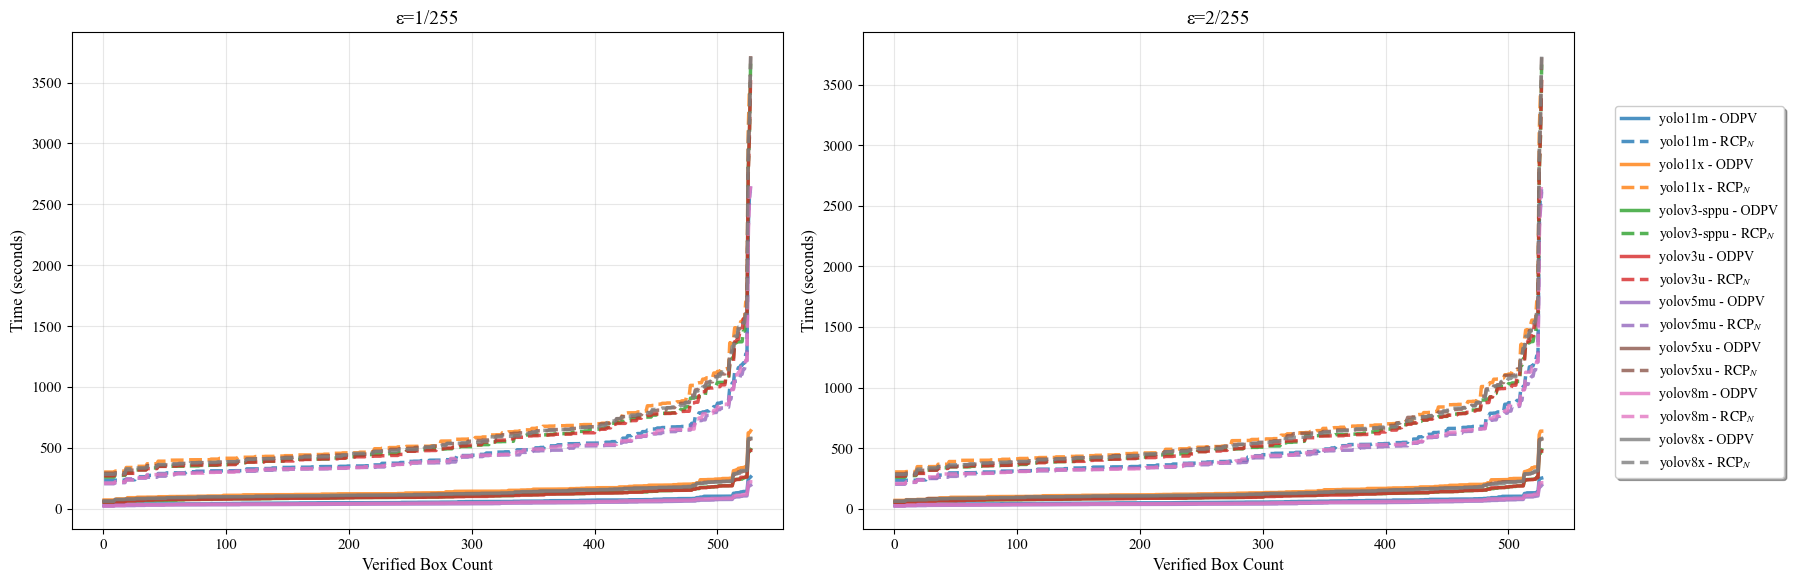

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],   # Windows 下常用名称
    'font.size': 12,                     # 全局字体大小（可调整）
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'mathtext.fontset': 'stix'           # 如果有 latex/mathtext，使字体匹配
})

# 读取数据
df = pd.read_csv(result_file)

# 筛选出odpv和rcp方法的数据
filtered_df = df[df['method'].isin(['odpv', 'rcp'])]

# 获取所有唯一的模型和epsilon值
models = filtered_df['model'].unique()
epsilons = filtered_df['epsilon'].unique()

# 为不同模型设置不同颜色
model_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
model_color_map = {model: model_colors[i % len(model_colors)] for i, model in enumerate(models)}

# 创建一行两列的子图
fig, axes = plt.subplots(1, len(epsilons), figsize=(16, 6))
if len(epsilons) == 1:
    axes = [axes]  # 确保axes是列表

for idx, epsilon in enumerate(epsilons):
    ax = axes[idx]
    epsilon_data = filtered_df[filtered_df['epsilon'] == epsilon]
    
    # 为每个模型和方法组合绘制曲线
    for model in models:
        model_data = epsilon_data[epsilon_data['model'] == model]
        
        if len(model_data) == 0:
            continue
            
        for method in ['odpv', 'rcp']:
            method_data = model_data[model_data['method'] == method]
            
            if len(method_data) == 0:
                continue
                
            # 按时间排序
            method_data = method_data.sort_values('time')
            
            # 计算累积的box数量（每一行代表一个box的验证）
            box_counts = range(1, len(method_data) + 1)
            times = method_data['time'].values
            
            # 设置线型和颜色
            linestyle = '-' if method == 'odpv' else '--'  # ODPV用实线，RCP用点线
            color = model_color_map[model]
            
            # 创建标签
            label = f'{model} - {method_rename_map[method]}'
            
            ax.plot(box_counts, times, 
                   linestyle=linestyle, 
                   color=color, 
                   linewidth=2.5,
                   label=label,
                   alpha=0.8)

    ax.set_xlabel('Verified Box Count', fontsize=12)
    ax.set_ylabel('Time (seconds)', fontsize=12)
    ax.set_title(f'ε={epsilon}', fontsize=14)
    ax.grid(True, alpha=0.3)

# 调整子图间距，为图例留出空间
plt.tight_layout()

# 收集图例信息（只从第一个有数据的子图获取）
handles = []
labels = []
for idx, epsilon in enumerate(epsilons):
    ax = axes[idx]
    if ax.get_legend_handles_labels()[0]:  # 如果这个子图有图例
        handles, labels = ax.get_legend_handles_labels()
        break  # 只从第一个有数据的子图获取图例信息

# 将统一的图例放到整个图的最右边
if handles:  # 确保有图例数据
    fig.legend(
        handles, labels,
        bbox_to_anchor=(1.01, 0.5), 
        loc='center left',
        fontsize=10,
        frameon=True,
        fancybox=True,
        shadow=True
    )

plt.savefig(data_dir / '../../image/verification_time_comparison.pdf', bbox_inches='tight')
# 显示统计信息
for epsilon in epsilons:
    print(f"\n=== ε={epsilon} 数据统计信息 ===")
    epsilon_data = filtered_df[filtered_df['epsilon'] == epsilon]
    for model in models:
        model_data = epsilon_data[epsilon_data['model'] == model]
        odpv_count = len(model_data[model_data['method'] == 'odpv'])
        rcp_count = len(model_data[model_data['method'] == 'rcp'])
        if odpv_count > 0 or rcp_count > 0:
            print(f"模型 {model}: ODPV={odpv_count} boxes, RCP={rcp_count} boxes")

# 计算平均时间统计
print("\n=== 平均时间统计 ===")
for epsilon in epsilons:
    print(f"\nε={epsilon}:")
    epsilon_data = filtered_df[filtered_df['epsilon'] == epsilon]
    
    for model in models:
        model_data = epsilon_data[epsilon_data['model'] == model]
        if len(model_data) == 0:
            continue
            
        print(f"  模型 {model}:")
        for method in ['odpv', 'rcp']:
            method_data = model_data[model_data['method'] == method]
            if len(method_data) > 0:
                avg_time = method_data['time'].mean()
                print(f"    {method.upper()}: 平均时间 = {avg_time:.2f}秒")